In [33]:
# Импортнем все сразу, чтобы не вспоминать
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter, defaultdict
import cv2
import numpy as np
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.models import resnet18
from torchvision.datasets import VOCDetection

from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm.auto import tqdm, trange

# Object Detection

У нас достаточно инструментов и знаний, чтобы попробовать сделать детекцию объектов.

## Определимся сначала с постановкой задачи

Пусть у нас есть картинки:
![Картинки](./img/plain-img.png)

Поручим людям пройтись по картинкам и отметить все интересующие нас объекты. Это можно сделать например следующими способами:

- boundary box (bbox или bb) -- прямоугольник `[x, y, w, h]` со сторонами параллельными краям картинки (самый простой вариант)
- instance/semantic mask -- картинка с нулями и единицами размером с исходную картинку, показывающая какие пиксели относятся к объекту (самый затратный вариант)

![Разметка](./img/img-with-annotation.png)

Можно размечать иначе под конкретные нужды:
- center + radius `[x, y, r]`
- rotated bbox `[angle, x, h, w, h]`
- ломанная окружающая линия `[(x_0, y_0), ... (x_n, y_n)]`
- whatever


**Итак: мы хотим сделать сеть, которая будет с одной картинки предсказывать положение (bbox) и класс нескольких объектов (из N классов)**


## Интерпретация feature maps

![](./img/backbone.png)

Если мы прогоним картинку `[3, W, H]` через привычную сверточную сеть (возьмем например классификационную сетку до GAP), мы получим тензор с большим количеством каналов небольшого пространственного размера `[ch, w, h]` (пространственные размеры пускай уменьшились K раз, K=32 для resnet50 **TODO: проверить размеры**).
Можно грубо сказать что каждый пиксель выходного тензора отвечает за область `KxK` пикселей входной картинки (рецептивно поле однако накрывает всю картинку с запасом). 

![](./img/img-with-grid.png)

Мы уже пытались интерпретировать пиксели в этом тензоре как Class Activation Map. Показывает что-то интересное, но как детектор явно не получится использовать.
Однако мы можем сформулировать детекцию как оптимизационную задачу и проучить модель специально под нее.
Давайте пойдем от идеи CAM и повесим на каждый пиксель выходной мапы несколько голов, которые будут предсказывать необходимые для детекции вещи. 

Договоримся, что пиксель относится к объекту только если его центр (точнее центр BBox'а) попадает в область действия пикселя.

![](./img/image-ssd.png)

Чтобы завести детекцию нам потребуются такие головы:

- `bbox regression` - регрессия bbox'а
- `objectness` - относится ли пиксель к объекту или нет
- `clf` - если относится, то давайте предскажем класс


Как мы когда-то обсуждали, Conv1x1 действует на каждый пиксель точно так же как FC-слой. Так что для наших нужд нам достаточно добавить к модели Conv1x1 с количеством выходных каналов `4 + 1 + N_classes`.

In [2]:
def monkey_forward(net, x):
    x = net.conv1(x)
    x = net.bn1(x)
    x = net.relu(x)
    x = net.maxpool(x)

    x = net.layer1(x)
    x = net.layer2(x)
    x = net.layer3(x)
    x = net.layer4(x)
    
    x = net.final(x) # [bs, 512, 7, 7]
    # x = net.avgpool(x) # [bs, 512, 1, 1]  # [..., dim]
    # x = torch.flatten(x, 1) # []
    # x = net.fc(x)
    return x

# Adapt torchvision classification model for detection

На первый взгляд нам надо только выбросить avgpool, однако [forward метод в torchvision.model.resnet написан неудачно для наших целей](https://pytorch.org/vision/stable/_modules/torchvision/models/resnet.html#resnet18), так что придется его запатчить.

**JFYI: подмена логики в рантайме (ака [monkey patching](https://en.wikipedia.org/wiki/Monkey_patch)) -- распространенная но _опасная_ практика**

# Prediction transformations

**Как превратить предсказанные числа в координаты bbox'ов?**

Пусть один пиксель выходного тензора относится к патчу (kx, ky) входной картинки.
BBox'ы живут в пространстве исходных картинок, непосредственные выходы сети -- в пространстве выходных тензоров.

Для удобства вычислений, давайте представим bbox как координаты центра (так будет удобнее регрессировать) + ширина и высота. Предсказываем 4 числа: $t_x, t_y, t_w, t_h$. `scale` -- это цена выходного пикселя во входных.

$$
x_c = s \cdot (\tanh t_x + i + 0.5)\\
y_c = s \cdot (\tanh t_y + j + 0.5)\\
w = s \cdot \exp{t_w}\\
h = s \cdot \exp{t_h}
$$

**NB: Обычно используют так называемые anchor -- затравочные bbox'ы, см whiteboard**

In [3]:
class VeryModel(nn.Module):
    def __init__(self, n_classes=12, cfg=None):
        super().__init__()
        self.n_classes = n_classes
        self.cfg = cfg
        model = resnet18(pretrained=True)
        # добавим в модельку слой и подменим forward
        model.final = nn.Conv2d(model.fc.in_features, 4 + 1 + n_classes, 1)
        model.forward = lambda x: monkey_forward(model, x)
        self.inner = model

    def forward(self, x):
        output = self.inner(x) # [bs, 5+N, 7, 7]
        _, _, W, H = x.shape
        bs, ch, w, h = output.shape
        # 5 + N = 4 (bbox) + obj + clf
        
        scale_x = W / w
        scale_y = H / h

        ox = torch.arange(w).view([1, 1, w, 1]).repeat(1, 1, 1, h) + 0.5
        oy = torch.arange(h).view([1, 1, 1, h]).repeat(1, 1, w, 1) + 0.5
        
        cx = scale_x * (torch.tanh(output[:, 0:1, ...]) + ox)
        cy = scale_y * (torch.tanh(output[:, 1:2, ...]) + oy)
        
        ww = scale_x * torch.exp(output[:, 2:3, ...])
        hh = scale_y * torch.exp(output[:, 3:4, ...])
        
        bb = torch.cat([cx, cy, ww, hh], dim=1)
        
        obj = output[:, 4:5, ...]
        clf = output[:, 5:, ...]
        
        return dict(
            bb=bb,
            obj=obj,
            clf=clf,
        )
    
    def compute_all(self, batch, device=None):
        loss = [obj > th](loc + clf) + obj
        pass
    
    
net = VeryModel()
net = net.eval()
with torch.no_grad():
    x = torch.zeros((1, 3, 416, 246))
    out = net(x)
    print(x.shape)
    for k, v in out.items():
        print(k, v.shape)

torch.Size([1, 3, 416, 246])
bb torch.Size([1, 4, 13, 8])
obj torch.Size([1, 1, 13, 8])
clf torch.Size([1, 12, 13, 8])


# WOK 
_Pascal VOC EDA_

Просто посмотреть, что у нас в датасете лежит

In [6]:
ds = VOCDetection("./voc", image_set="train")
# print(ds[0])
some_stats = defaultdict(list)
N = len(ds)

for i in trange(N):
    pic, ddict = ds[i]
    anno = ddict['annotation']
    w = int(anno['size']['width'])
    h = int(anno['size']['height'])
    d = int(anno['size']['depth'])
    
    some_stats['w'].append(w)
    some_stats['h'].append(h)
    some_stats['d'].append(d)
    
    some_stats['objects_per_image'].append(len(anno['object']))
    for x in anno['object']:
        name = x['name']
        bb = x['bndbox']
        ww = int(bb['xmax']) - int(bb['xmin'])
        hh = int(bb['ymax']) - int(bb['ymin'])
        aspect = (ww / hh + 1e-5)
        rel_ww = ww / w
        rel_hh = hh / h
        
        some_stats['name'].append(name)
        some_stats['ww'].append(ww)
        some_stats['hh'].append(hh)
        some_stats['aspect'].append(aspect)
        some_stats['rel_ww'].append(rel_ww)
        some_stats['rel_hh'].append(rel_hh)

[('person', 5019), ('chair', 1457), ('car', 1191), ('dog', 768), ('bottle', 749), ('cat', 609), ('bird', 592), ('pottedplant', 557), ('sheep', 509), ('boat', 508), ('aeroplane', 470), ('tvmonitor', 412), ('bicycle', 410), ('sofa', 399), ('horse', 377), ('motorbike', 375), ('diningtable', 373), ('cow', 355), ('train', 327), ('bus', 317)]


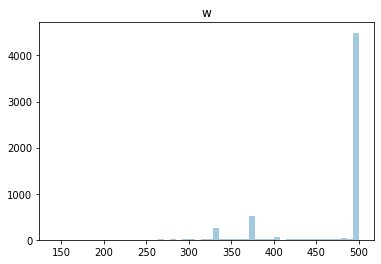

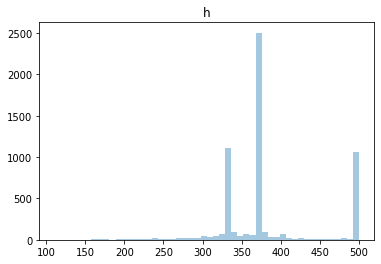

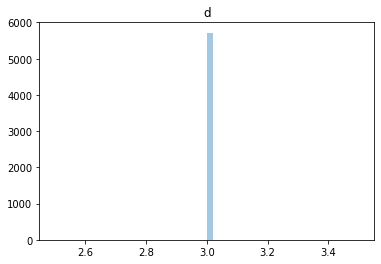

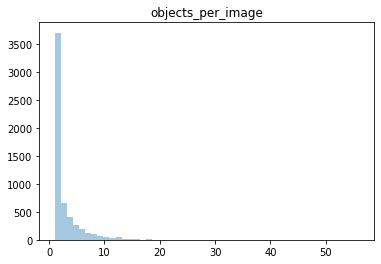

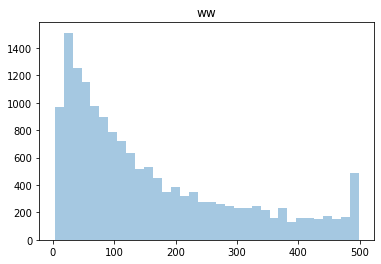

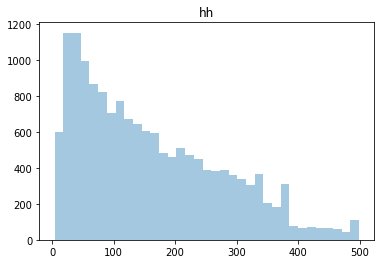

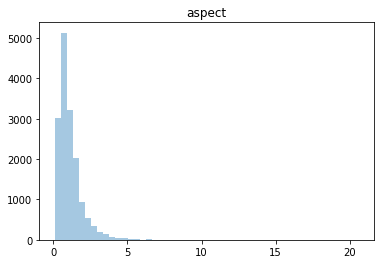

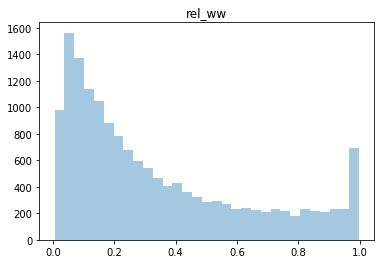

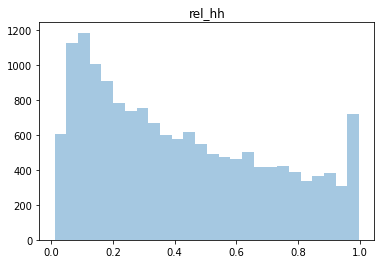

In [7]:
# names
print(sorted(Counter(some_stats['name']).items(), key=lambda t: -t[1]))
del some_stats['name']
for k, v in some_stats.items():  
    plt.figure()
    plt.title(k)
    sns.distplot(v, kde=False)
    plt.show()

# Let's prepare data


In [47]:
CLASSES = [
    'person', 'chair', 'car', 'dog', 'bottle', 'cat', 'bird', 'pottedplant', 
    'sheep', 'boat', 'aeroplane', 'tvmonitor', 'bicycle', 'sofa', 
    'horse', 'motorbike', 'diningtable', 'cow', 'train', 'bus',
]

cls2idx = {k: i for i, k in enumerate(CLASSES)}

# unused
def process_image(pil_image):
    img = np.asarray(pil_image)
    img = img.astype(np.float32) / 255.0 # img \in [0, 1]
    mean = np.array([0.485, 0.456, 0.406]).reshape(1, 1, 3)
    std =  np.array([0.229, 0.224, 0.225]).reshape(1, 1, 3)
    img = (img - mean) / std
    img = img.astype(np.float32)
    img = np.transpose(img, [2, 0, 1])
    return img

class Verydet:
    def __init__(self, root, image_set="train", download=True, transform_fn=None):
        self.dataset = VOCDetection(root, image_set=image_set, download=download)
        self.transform_fn = transform_fn
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, item):
        pil_image, ddict = self.dataset[item]
        img = np.asarray(pil_image)      
        ddict = ddict['annotation']
        
        category_ids = []
        bboxes = []
        for x in ddict['object']:
            category_ids.append(cls2idx[x['name']])
            bb = {k: int(v) for k, v in x['bndbox'].items()}
            bboxes.append(tuple([bb[_] for _ in ["xmin", "ymin", "xmax", "ymax"]]))
        ret = {"image": img, "category_ids": category_ids, "bboxes": bboxes}
        if self.transform_fn is not None:
            ret = self.transform_fn(**ret)
        return ret


trainset = Verydet("./voc", image_set="train", download=True)
valset = Verydet("./voc", image_set="val", download=True)

Using downloaded and verified file: ./voc/VOCtrainval_11-May-2012.tar
Using downloaded and verified file: ./voc/VOCtrainval_11-May-2012.tar


In [6]:
trainset[0]

{'img': array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [202, 205, 248],
         [203, 206, 249],
         [204, 207, 250]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [203, 206, 249],
         [203, 206, 249],
         [202, 205, 248]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [206, 209, 252],
         [205, 208, 251],
         [205, 208, 251]],
 
        ...,
 
        [[205, 191, 178],
         [194, 180, 167],
         [206, 192, 179],
         ...,
         [137, 128, 119],
         [120, 112, 101],
         [119, 113, 101]],
 
        [[192, 178, 165],
         [193, 179, 166],
         [193, 179, 166],
         ...,
         [111, 106, 100],
         [108, 103,  97],
         [122, 119, 110]],
 
        [[178, 164, 151],
         [180, 166, 153],
         [185, 171, 158],
         ...,
         [ 82,  77,  

# Форматы bbox'ов

Шпаргалка из albumentations:

The `coco` format `[x_min, y_min, width, height]`, e.g. [97, 12, 150, 200].


The `pascal_voc` format `[x_min, y_min, x_max, y_max]`, e.g. [97, 12, 247, 212].


The `albumentations` format is like `pascal_voc`, but normalized,
in other words: `[x_min, y_min, x_max, y_max]`, e.g. [0.2, 0.3, 0.4, 0.5].


The `yolo` format `[x, y, width, height]`, e.g. [0.1, 0.2, 0.3, 0.4]; 
`x`, `y` - normalized bbox center; `width`, `height` - normalized bbox width and height.

(53, 87, 471, 420) horse
(158, 44, 289, 167) person


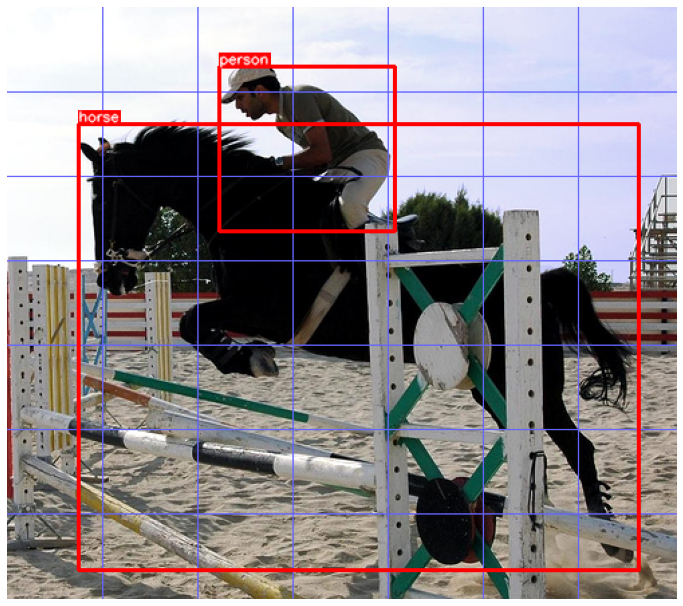

In [24]:
# based on albumentation tutorial 
# https://albumentations.ai/docs/examples/example_bboxes2/

BOX_COLOR = (255, 0, 0) # Red
LINE_COLOR = (100, 100, 255)
TEXT_COLOR = (255, 255, 255) # White


def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
#     x_min, y_min, w, h = bbox
#     x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
    x_min, y_min, x_max, y_max = [int(_) for _ in bbox]

    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)

    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img


def visualize(image, bboxes, category_ids, category_id_to_name, grid=None, centers=False, target_obj_mask=None):
    img = image.copy()
    if grid is not None:
        height, width, _ = img.shape
        nh, nw = grid
        
        for i in range(1, nw):
            x = (width // nw) * i
            cv2.line(img, (x, 0), (x, height), LINE_COLOR, 1)
        
        for j in range(1, nh):
            y = (height // nh) * j
            cv2.line(img, (0, y), (width, y), LINE_COLOR, 1)

    for bbox, category_id in zip(bboxes, category_ids):
        class_name = category_id_to_name[category_id]
        print(bbox, class_name)
        img = visualize_bbox(img, bbox, class_name)
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(img)
    
entry = trainset[0]
visualize(entry['image'], entry['bboxes'], entry['category_ids'], CLASSES, grid=(7, 7))

# Оси, координаты, картинки и opencv

Порядок осей в тензорах, с которым мы работаем обычно называют `channels_first`, он же `NCHW`, картиночные размерности идут в порядке высота, ширина.

При этом, рисовательные функции opencv подразумевают, что координаты точек -- это `(x, y)`.
Это просто кладезь ошибок.
Поэтому всегда стоит тестировать модельки/пайплайны на неквадратных картинках и посматривать на недиагональные элементы (на них сложно отловить ошибку).


Как себя проверять? Через визуализацию и unit-тесты.


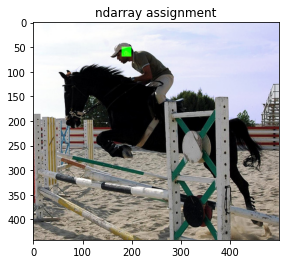

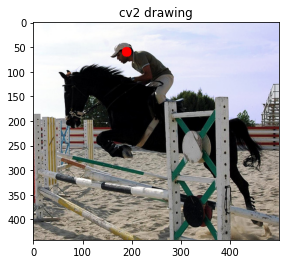

In [12]:
ds = VOCDetection("./voc", image_set="train")
img = np.asarray(ds[0][0])
# Direct pixel manipulation: y-coord, x-coord
img1 = img.copy()
img1[60-10: 60+10, 190-10: 190+10, 1] = 255

# Drawing x-coord, y-coord
img2 = img.copy()
cv2.circle(img2, (190, 60), 10, (255, 0, 0), -1)

plt.figure()
plt.title("ndarray assignment")
plt.imshow(img1)
plt.show()

plt.figure()
plt.title("cv2 drawing")
plt.imshow(img2)
plt.show()



(416, 416, 3)
(0.0, 0.0, 212.94871875679678, 259.8569453739596) person
(132.98248217890176, 238.31651620616987, 195.53049509451944, 299.35625842386867) dog


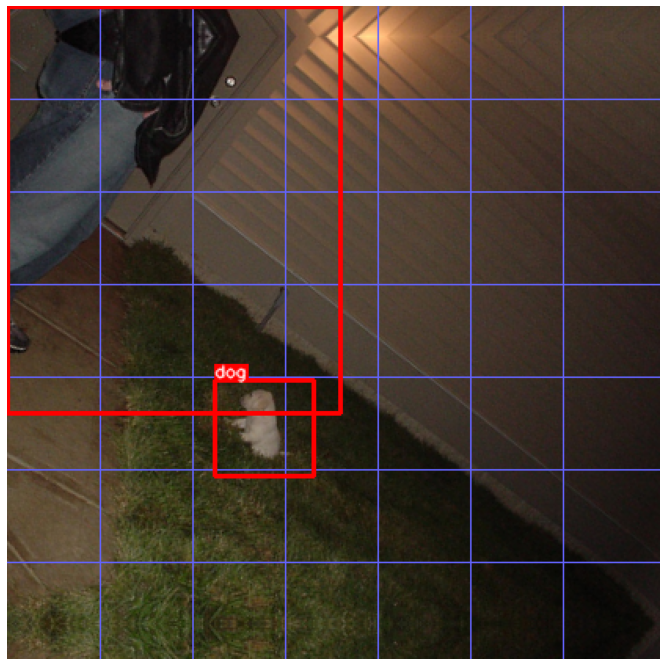

In [43]:
import albumentations as A
import albumentations.pytorch.transforms as APT

np.random.seed(7)
transform = A.Compose(
    [
        A.ShiftScaleRotate(p=0.5), 
        A.PadIfNeeded(min_height=420, min_width=420), 
        A.RandomCrop(416, 416, always_apply=True),
#         A.Normalize(),
#         APT.ToTensorV2(always_apply=True),
    ],
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category_ids']),
)

entry = trainset[200]
transformed = transform(**entry)
print(transformed['image'].shape)

visualize(transformed['image'], transformed['bboxes'], transformed['category_ids'], CLASSES, grid=(7, 7))

In [50]:
def collate_fn(lst):
    tmp = defaultdict(list)
    ret = dict()
    for entry in lst:
        for k, v in entry.items():
            tmp[k].append(v)
    
    for k, v in tmp.items():
        if isinstance(v[0], np.ndarray):
            for vv in v:
                print(vv.shape)
            v = np.concatenate(v, 0)
        if isinstance(v[0], torch.Tensor):
            v = torch.cat(v, 0)
        ret[k] = v
    return ret


trainset = Verydet("./voc", image_set="train", transform_fn=transform)
# valset = Verydet("./voc", image_set="val", transform_fn=transform)

dl = DataLoader(trainset, shuffle=True, batch_size=4, collate_fn=collate_fn)
batch = next(iter(dl))

Using downloaded and verified file: ./voc/VOCtrainval_11-May-2012.tar
Using downloaded and verified file: ./voc/VOCtrainval_11-May-2012.tar
(416, 416, 3)
(416, 416, 3)
(416, 416, 3)
(416, 416, 3)


{'image': array([[[196, 109,  89],
         [196, 129, 102],
         [196, 139,  96],
         ...,
         [250, 249, 247],
         [255, 255, 250],
         [254, 255, 253]],
 
        [[189, 101,  89],
         [179, 102,  84],
         [192,  94,  91],
         ...,
         [255, 255, 244],
         [255, 252, 253],
         [172, 154, 194]],
 
        [[226, 168, 146],
         [189, 170, 127],
         [240, 166, 139],
         ...,
         [255, 253, 255],
         [191, 165, 226],
         [ 79,  44, 126]],
 
        ...,
 
        [[ 97,  89,  86],
         [ 96,  89,  85],
         [ 96,  89,  83],
         ...,
         [114, 107,  97],
         [111, 104,  95],
         [108, 101,  92]],
 
        [[ 96,  88,  85],
         [ 95,  87,  83],
         [ 99,  92,  86],
         ...,
         [117, 109, 101],
         [117, 109, 101],
         [106,  99,  91]],
 
        [[ 97,  89,  86],
         [ 98,  91,  86],
         [ 98,  91,  85],
         ...,
         [113, 104,

In [8]:
class Trainer:
    def __init__(self, model: nn.Module,
                 batch_size: int = 128):
        self.model = model
        self.batch_size = batch_size

        run_folder = Path(os.get_cwd())
        train_log_folder = run_folder / "train_log"
        val_log_folder = run_folder / "val_log"
        print(f"Run output folder is {run_folder}")
        os.makedirs(run_folder)
        os.makedirs(train_log_folder)
        os.makedirs(val_log_folder)

        self.outpath = outpath
        self.device = 'cpu'
        if torch.cuda.is_available():
            self.device = torch.cuda.current_device()
            self.model = self.model.to(self.device)

        self.global_step = 0
        self.train_writer = SummaryWriter(log_dir=str(train_log_folder))
        self.val_writer = SummaryWriter(log_dir=str(val_log_folder))

    def save_checkpoint(self, path):
        torch.save(self.model.state_dict(), path)

    def train(self, num_epochs: int):
        model = self.model
        optimizer = model.get_optimizer()

        train_loader = model.get_loader(train=True)
        val_loader = model.get_loader(train=False)

        best_loss = float('inf')

        for epoch in range(num_epochs):
            model.train()
            for batch in tqdm(train_loader):
                batch = {k: v.to(self.device) for k, v in batch.items()}
                loss, details = model.compute_all(batch)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                model.post_train_batch()
                for k, v in details.items():
                    self.train_writer.add_scalar(k, v, global_step=self.global_step)
                self.global_step += 1

            model.eval()
            val_losses = []
            for batch in tqdm(val_loader):
                batch = {k: v.to(self.device) for k, v in batch.items()}
                loss, details = model.compute_all(batch)
                val_losses.append(loss.item())

            val_loss = np.mean(val_losses)
            model.post_val_stage(val_loss)

            if val_loss < best_loss:
                self.save_checkpoint(str(self.run_folder / "best_checkpoint.pth"))
                best_loss = val_loss

    def find_lr(self, min_lr: float = 1e-6,
                max_lr: float = 1e-1,
                num_lrs: int = 20,
                smooth_beta: float = 0.8) -> dict:
        lrs = np.geomspace(start=min_lr, stop=max_lr, num=num_lrs)
        logs = {'lr': [], 'loss': [], 'avg_loss': []}
        avg_loss = None
        model = self.model
        optimizer = model.get_optimizer()
        train_loader = model.get_loader(train=True)

        model.train()
        for lr, batch in tqdm(zip(lrs, train_loader), desc='finding LR', total=num_lrs):
            # apply new lr
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr

            # train step
            batch = {k: v.to(self.device) for k, v in batch.items()}
            loss, details = model.compute_all(batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # calculate smoothed loss
            if avg_loss is None:
                avg_loss = loss
            else:
                avg_loss = smooth_beta * avg_loss + (1 - smooth_beta) * loss

            # store values into logs
            logs['lr'].append(lr)
            logs['avg_loss'].append(avg_loss)
            logs['loss'].append(loss)

        logs.update({key: np.array(val) for key, val in logs.items()})

        return logs